In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install fuzzywuzzy
!pip install surprise

     |████████████████████████████████| 11.8MB 12.7MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670926 sha256=38aee9d94ef5214c1bcf174ff12269d69784dc428910cbaf6d4566f4bc263ed2
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [3]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBasic, KNNBaseline, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.dataset import DatasetAutoFolds
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

In [4]:
def drop_small_num_review_movies(rating_df, movie_count_df, review_num_threshold):
    popular_movies = list(set(movie_count_df.query('count >= @review_num_threshold').index))
    return rating_df[rating_df.movieId.isin(popular_movies)]

In [5]:
def drop_small_num_review_users(rating_df, user_count_df, review_num_threshold):
    active_users = list(set(user_count_df.query('count >= @review_num_threshold').index))
    return rating_df[rating_df.userId.isin(active_users)]

# 데이터 불러오기

In [99]:
df_movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BigData_2020(2)/ml-latest-small/movies.csv', usecols=['movieId', 'title'])
df_ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BigData_2020(2)/ml-latest-small/ratings.csv', usecols=['userId', 'movieId', 'rating'])

num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
print('점수 안 매긴 갯수 :', rating_zero_cnt)

There are 610 unique users and 9724 unique movies in this data set
점수 안 매긴 갯수 : 5830804


# 데이터 자체가 Sparse함을 보임

In [100]:
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])

# 점수 안 매긴 것 0점으로 처리
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


Text(0, 0.5, 'number of ratings(Log)')

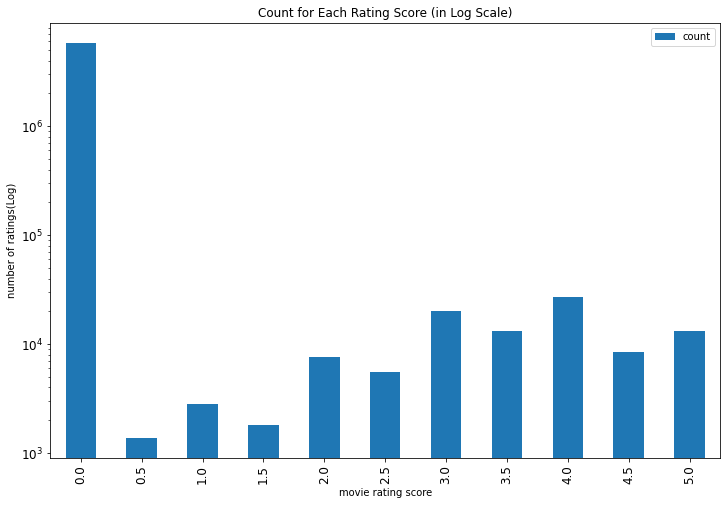

In [101]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings(Log)")

## 각 영화별 매겨진 리뷰의 갯수 (실질적으로 리뷰가 적은 영화가 꽤 많음 - 무의미한 데이터)


Text(0, 0.5, 'number of ratings (log scale)')

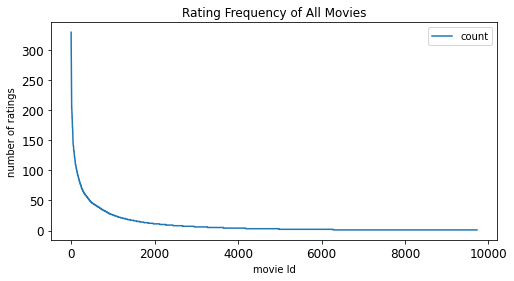

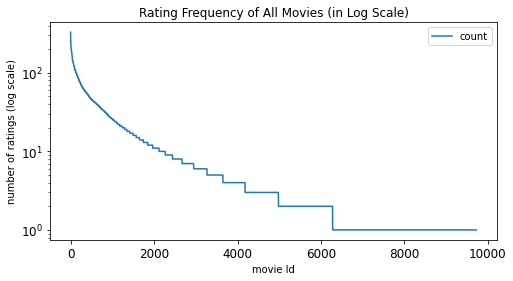

In [102]:
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
ax = df_movies_cnt.sort_values('count', ascending=False).reset_index(drop=True) \
    .plot(
        figsize=(8, 4),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

# log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(8, 4),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

In [103]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

# 상위 1%가 329개 평가를 받았고
# 상위 5%는 47개 평가
# 상위 20% 아래는 10개 이하의 평가를 기록

1.00    329.0
0.95     47.0
0.90     27.0
0.85     17.0
0.80     12.0
0.75      9.0
0.70      7.0
0.65      5.0
Name: count, dtype: float64

In [104]:
df_ratings_drop_movies = drop_small_num_review_movies(df_ratings, df_movies_cnt, 10)
print('기존 데이터: ', df_ratings.shape)
print('리뷰 수가 적은 영화를 제거한 데이터: ', df_ratings_drop_movies.shape)
df_ratings_drop_movies.head()

기존 데이터:  (100836, 3)
리뷰 수가 적은 영화를 제거한 데이터:  (81116, 3)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## 각 유저별 남긴 리뷰의 갯수(리뷰를 적게 남긴 유저가 많음 - 무의미한 추천이 될 확률이 높은 유저들)

In [105]:
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,211
2,26
3,24
4,179
5,44


Text(0, 0.5, 'number of ratings')

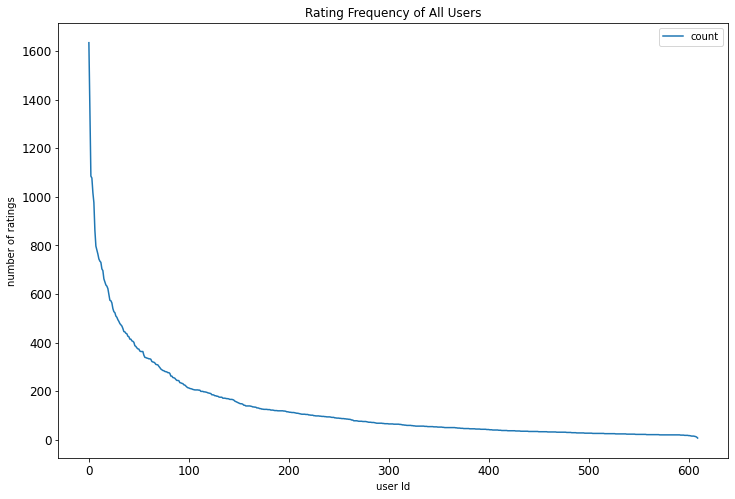

In [106]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [107]:
df_users_cnt['count'].quantile(np.arange(1, 0.0, -0.05))
# 상위 1%는 1634개 평가
# 상위 5%는 약 482개 평가

1.00    1634.00
0.95     482.95
0.90     333.00
0.85     234.65
0.80     190.20
0.75     148.00
0.70     122.00
0.65     105.00
0.60      92.00
0.55      75.00
0.50      64.50
0.45      56.00
0.40      50.00
0.35      43.00
0.30      36.70
0.25      33.00
0.20      28.80
0.15      25.00
0.10      22.00
0.05      20.00
Name: count, dtype: float64

In [108]:
df_ratings_drop_users = drop_small_num_review_users(df_ratings_drop_movies, df_users_cnt, 50)
print('기존 데이터: ', df_ratings.shape)
print('리뷰 수가 적은 영화를 제거한 데이터: ', df_ratings_drop_movies.shape)
print('리뷰 수가 적은 사용자를 제거한 데이터: ', df_ratings_drop_users.shape)
df_ratings_drop_users.head()

기존 데이터:  (100836, 3)
리뷰 수가 적은 영화를 제거한 데이터:  (81116, 3)
리뷰 수가 적은 사용자를 제거한 데이터:  (73868, 3)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


# Surprise 적용

In [109]:
series_dict = {}
df = drop_small_num_review_users(drop_small_num_review_movies(df_ratings, df_movies_cnt, 10), df_users_cnt, 50)

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader=reader)

results = cross_validate(KNNBasic(), data, measures=['RMSE'], cv=3, verbose=False)
temp = pd.DataFrame.from_dict(results).mean(axis=0)[['test_rmse']]
series_dict.update({(10, 50):temp.item()})
series = pd.Series(series_dict)

p = series.to_frame()

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


# 영화의 최저 리뷰 개수, 유저의 최저 리뷰 개수 다양화 테스트

In [ ]:
series_dict = {}

for movie_review_num_threshold in range(5, 15):
    for user_review_num_threshold in range(10, 50):
        df = drop_small_num_review_users(drop_small_num_review_movies(df_ratings, df_movies_cnt, movie_review_num_threshold), df_users_cnt, user_review_num_threshold)
        reader = Reader(rating_scale=(0.5, 5))
        data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader=reader)

        results = cross_validate(KNNBasic(), data, measures=['RMSE'], cv=3, verbose=False)
        temp = pd.DataFrame.from_dict(results).mean(axis=0)[['test_rmse']]
        series_dict.update({(movie_review_num_threshold, user_review_num_threshold):temp.item()})

In [84]:
result = pd.Series(series_dict).to_frame()
result.columns = ["RMSE"]
result.index.names = ["m_thres", "u_thres"]
result.sort_values(by=["RMSE"], axis=0).head(20)

RMSE
m_thres u_thres          
14      37       0.901701
        48       0.902157
        38       0.902251
        40       0.902256
        41       0.902551
12      29       0.902563
14      39       0.902795
        43       0.902805
        42       0.902816
        26       0.902819
13      41       0.902899
14      29       0.903001
13      30       0.903049
14      44       0.903065
        31       0.903180
13      40       0.903250
        42       0.903256
        45       0.903414
        37       0.903582
        44       0.903720

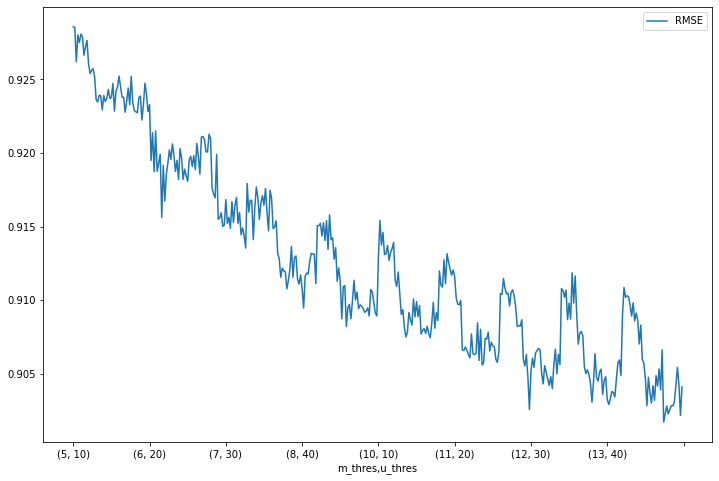

In [93]:
ax = result.plot(
    figsize=(12,8)
)

In [93]:
drops = drop_small_num_review_users(drop_small_num_review_movies(df_ratings, df_movies_cnt, 14), df_users_cnt, 37)
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(drops[['userId', 'movieId', 'rating']], reader=reader)
train, test = train_test_split(data, test_size=0.25, random_state=42)

algo = KNNBasic()
cross_validate(algo, data, measures=["RMSE"], cv=3, verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


{'fit_time': (0.05498051643371582, 0.06715869903564453, 0.06648778915405273),
 'test_rmse': array([0.906633  , 0.89862633, 0.90631333]),
 'test_time': (2.0542736053466797, 1.903160572052002, 2.0084123611450195)}

In [94]:
predictions = algo.fit(train).test(test)
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9082


0.9082006852116778

In [95]:
def get_Iu(uid):
    try:
        return len(train.ur[train.to_inner_uid(uid)])
    except ValueError:
        return 0

def get_Ui(iid):
    try:
        return len(train.ir[train.to_inner_iid(iid)])
    except ValueError:
        return 0 

asd = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
asd['Iu'] = asd.uid.apply(get_Iu)
asd['Ui'] = asd.iid.apply(get_Ui)
asd['err'] = abs(asd.est - asd.rui)
asd.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,249,82459,4.5,3.979011,"{'actual_k': 23, 'was_impossible': False}",488,23,0.520989
1,279,608,2.0,4.328366,"{'actual_k': 40, 'was_impossible': False}",118,121,2.328366
2,561,293,4.0,4.109475,"{'actual_k': 40, 'was_impossible': False}",329,94,0.109475
3,477,48516,5.0,4.352225,"{'actual_k': 40, 'was_impossible': False}",377,76,0.647775
4,190,4995,4.0,3.913398,"{'actual_k': 40, 'was_impossible': False}",46,89,0.086602


In [96]:
best_predictions = asd.sort_values(by='err')[:10]
worst_predictions = asd.sort_values(by='err')[-10:]

In [97]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
10962,387,1210,4.0,4.000005,"{'actual_k': 40, 'was_impossible': False}",435,138,0.000005
11151,415,4369,3.0,3.000246,"{'actual_k': 36, 'was_impossible': False}",68,36,0.000246
15963,590,344,3.0,2.999681,"{'actual_k': 40, 'was_impossible': False}",460,90,0.000319
6973,309,898,4.5,4.500487,"{'actual_k': 19, 'was_impossible': False}",54,19,0.000487
14094,249,33615,3.5,3.499509,"{'actual_k': 26, 'was_impossible': False}",488,26,0.000491
13855,298,77561,3.5,3.499317,"{'actual_k': 28, 'was_impossible': False}",471,28,0.000683
3323,480,7438,4.0,3.999277,"{'actual_k': 40, 'was_impossible': False}",505,82,0.000723
7406,304,1035,4.0,4.000726,"{'actual_k': 40, 'was_impossible': False}",146,44,0.000726
11325,178,8874,4.0,3.998977,"{'actual_k': 40, 'was_impossible': False}",53,59,0.001023
13934,434,1580,3.5,3.498972,"{'actual_k': 40, 'was_impossible': False}",171,120,0.001028


In [98]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
6836,21,66934,0.5,4.060220,"{'actual_k': 16, 'was_impossible': False}",246,16,3.560220
4585,517,68157,0.5,4.062432,"{'actual_k': 40, 'was_impossible': False}",206,50,3.562432
7609,365,4226,0.5,4.074613,"{'actual_k': 40, 'was_impossible': False}",125,106,3.574613
7835,111,593,0.5,4.108637,"{'actual_k': 40, 'was_impossible': False}",270,176,3.608637
1822,153,2959,0.5,4.126020,"{'actual_k': 40, 'was_impossible': False}",108,149,3.626020
1619,76,1148,0.5,4.151492,"{'actual_k': 36, 'was_impossible': False}",79,36,3.651492
15998,159,3147,0.5,4.206503,"{'actual_k': 40, 'was_impossible': False}",65,70,3.706503
5285,125,4973,0.5,4.271459,"{'actual_k': 40, 'was_impossible': False}",133,90,3.771459
14036,580,1203,0.5,4.349283,"{'actual_k': 39, 'was_impossible': False}",274,39,3.849283
6513,365,593,0.5,4.382391,"{'actual_k': 40, 'was_impossible': False}",125,176,3.882391


# 최악 RMSE로 결과 비교


In [112]:
drops = drop_small_num_review_users(drop_small_num_review_movies(df_ratings, df_movies_cnt, 5), df_users_cnt, 10)
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(drops[['userId', 'movieId', 'rating']], reader=reader)
train, test = train_test_split(data, test_size=0.25, random_state=42)

algo = KNNBasic()
cross_validate(algo, data, measures=["RMSE"], cv=3, verbose=False)

predictions = algo.fit(train).test(test)
accuracy.rmse(predictions)


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9226


0.9226412470521642

In [ ]:
asd = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
asd['Iu'] = asd.uid.apply(get_Iu)
asd['Ui'] = asd.iid.apply(get_Ui)
asd['err'] = abs(asd.est - asd.rui)

In [114]:
best_predictions = asd.sort_values(by='err')[:10]
worst_predictions = asd.sort_values(by='err')[-10:]

In [115]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
3350,610,95088,4.0,4.0,"{'actual_k': 3, 'was_impossible': False}",702,3,0.0
10514,182,3915,4.0,4.0,"{'actual_k': 4, 'was_impossible': False}",624,4,0.0
12624,28,3783,4.0,4.0,"{'actual_k': 4, 'was_impossible': False}",375,4,0.0
12554,586,122890,4.0,4.0,"{'actual_k': 2, 'was_impossible': False}",150,2,0.0
16745,603,3783,4.0,4.0,"{'actual_k': 4, 'was_impossible': False}",549,4,0.0
953,383,2961,3.0,3.0,"{'actual_k': 1, 'was_impossible': False}",24,2,0.0
4823,90,735,4.0,4.0,"{'actual_k': 5, 'was_impossible': False}",26,6,0.0
21548,603,2940,4.0,4.0,"{'actual_k': 5, 'was_impossible': False}",549,5,0.0
19686,111,104218,4.5,4.5,"{'actual_k': 1, 'was_impossible': False}",362,1,0.0
8509,152,64620,4.0,4.0,"{'actual_k': 4, 'was_impossible': False}",50,4,0.0


In [116]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
3855,111,2571,0.5,4.165998,"{'actual_k': 40, 'was_impossible': False}",362,203,3.665998
18486,461,457,0.5,4.169275,"{'actual_k': 40, 'was_impossible': False}",23,140,3.669275
16185,256,5618,0.5,4.198673,"{'actual_k': 40, 'was_impossible': False}",120,64,3.698673
11796,3,527,0.5,4.221449,"{'actual_k': 40, 'was_impossible': False}",23,165,3.721449
15333,298,6385,0.5,4.226150,"{'actual_k': 10, 'was_impossible': False}",665,10,3.726150
2,365,593,0.5,4.268035,"{'actual_k': 40, 'was_impossible': False}",177,211,3.768035
12141,83,1223,0.5,4.359858,"{'actual_k': 22, 'was_impossible': False}",78,23,3.859858
19920,22,60766,0.5,4.382480,"{'actual_k': 5, 'was_impossible': False}",89,5,3.882480
12100,487,86345,0.5,4.427162,"{'actual_k': 3, 'was_impossible': False}",41,3,3.927162
18947,543,213,0.5,4.810636,"{'actual_k': 4, 'was_impossible': False}",48,4,4.310636


# 예측 실패

In [86]:
# drops = drop_small_num_review_users(drop_small_num_review_movies(df_ratings, df_movies_cnt, 5), df_users_cnt, 5)
# reader = Reader(rating_scale=(0.5, 5))
# data = Dataset.load_from_df(drops[['userId', 'movieId', 'rating']], reader=reader)
# # train, test = train_test_split(data, test_size=0.1, random_state=42)
# train = data.build_full_trainset()
# # algo = KNNBasic()
# algo = SVD(n_factors=50, n_epochs=20, random_state=42)
# algo.fit(train)

# movieIds = drops[drops['userId']==9]['movieId']
# if movieIds[movieIds==42].count() == 0:
#     print('user 9, movidId 42 에 대한 평점 없음')
# print(df_movies[df_movies['movieId']==42])

user 9, movidId 42 에 대한 평점 없음
    movieId                   title
38       42  Dead Presidents (1995)


In [87]:
# def get_unseen_surprise(ratings, movies, userId):
#     seen_movies = drops[drops['userId']==userId]['movieId'].tolist()
#     total_movies = df_movies['movieId'].tolist()
#     unseen_movies = [movie for movie in total_movies if movie not in seen_movies]
#     print(f'유저 : {userId}\n본 영화수 : {len(seen_movies)}\n전체 영화수 : {len(total_movies)}')
#     return unseen_movies

# def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):
#     predictions = [algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]
#     def sortkey_est(pred):
#         return pred.est
#     predictions.sort(key=sortkey_est, reverse=True)
#     top_predictions = predictions[:top_n]

#     top_movie_ids = [int(pred.iid) for pred in top_predictions]
#     top_movie_ratings = [pred.est for pred in top_predictions]
#     top_movie_titles = df_movies[df_movies.movieId.isin(top_movie_ids)]['title']
#     top_movie_preds = [(ids, rating, title) for ids, rating, title in zip(top_movie_ids, top_movie_ratings, top_movie_titles)]

#     return top_movie_preds

In [91]:
# search_user_id = 18
# search_movie_id = 42
# unseen_list = get_unseen_surprise(drops, df_movies, search_user_id)
# top_movies_preds = recomm_movie_by_surprise(algo, search_user_id, unseen_list, top_n=10)

# print()
# for top_movie in top_movies_preds:
#     print('영화 이름 :', top_movie[2])
#     print('예측 평점 :', top_movie[1])
#     print()

유저 : 18
본 영화수 : 455
전체 영화수 : 9742

영화 이름 : Grumpier Old Men (1995)
예측 평점 : 3.537358486385892

영화 이름 : Waiting to Exhale (1995)
예측 평점 : 3.537358486385892

영화 이름 : Father of the Bride Part II (1995)
예측 평점 : 3.537358486385892

영화 이름 : Sabrina (1995)
예측 평점 : 3.537358486385892

영화 이름 : Tom and Huck (1995)
예측 평점 : 3.537358486385892

영화 이름 : Sudden Death (1995)
예측 평점 : 3.537358486385892

영화 이름 : GoldenEye (1995)
예측 평점 : 3.537358486385892

영화 이름 : American President, The (1995)
예측 평점 : 3.537358486385892

영화 이름 : Dracula: Dead and Loving It (1995)
예측 평점 : 3.537358486385892

영화 이름 : Balto (1995)
예측 평점 : 3.537358486385892



<br></br>
# 190MB Dataset
<br></br>

In [4]:
# d_movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BigData_2020(2)/ml-20m/movies.csv', usecols=['movieId', 'title'])
# d_ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BigData_2020(2)/ml-20m/ratings.csv', usecols=['userId', 'movieId', 'rating'])

# _num_users = len(d_ratings.userId.unique())
# _num_items = len(d_ratings.movieId.unique())
# print('There are {} unique users and {} unique movies in this data set'.format(_num_users, _num_items))

There are 138493 unique users and 26744 unique movies in this data set


In [5]:
# _total_cnt = _num_users * _num_items
# _rating_zero_cnt = _total_cnt - d_ratings.shape[0]
# print('점수 안 매긴 갯수 :', _rating_zero_cnt)

# d_ratings_cnt_tmp = pd.DataFrame(d_ratings.groupby('rating').size(), columns=['count'])
# d_ratings_cnt = d_ratings_cnt_tmp.append(
#     pd.DataFrame({'count': _rating_zero_cnt}, index=[0.0]),
#     verify_integrity=True,
# ).sort_index()
# d_ratings_cnt

점수 안 매긴 갯수 : 3683856529


,count
0.0,3683856529
0.5,239125
1.0,680732
1.5,279252
2.0,1430997
2.5,883398
3.0,4291193
3.5,2200156
4.0,5561926
4.5,1534824


In [6]:
# d_movies_cnt = pd.DataFrame(d_ratings.groupby('movieId').size(), columns=['count'])
# d_movies_cnt['count'].quantile(np.arange(1, 0.40, -0.05))
# # 상위 1%가 67310개 평가를 받았고
# # 상위 5%는 3612개 평가
# # 상위 55~60% 아래는 10개 이하의 평가를 기록

1.00    67310.00
0.95     3612.95
0.90     1305.70
0.85      632.55
0.80      346.00
0.75      205.00
0.70      123.00
0.65       74.00
0.60       47.00
0.55       29.00
0.50       18.00
0.45       12.00
Name: count, dtype: float64

In [7]:
# d_users_cnt = pd.DataFrame(d_ratings.groupby('userId').size(), columns=['count'])
# d_users_cnt['count'].quantile(np.arange(1, 0.0, -0.05))
# # 상위 1%는 9254개 평가
# # 상위 5%는 약 520개 평가
# # 상위 95%는 약 20개 평가

1.00    9254.0
0.95     520.0
0.90     334.0
0.85     246.0
0.80     193.0
0.75     155.0
0.70     127.0
0.65     108.0
0.60      93.0
0.55      79.0
0.50      68.0
0.45      59.0
0.40      51.0
0.35      45.0
0.30      39.0
0.25      35.0
0.20      30.0
0.15      27.0
0.10      24.0
0.05      21.0
Name: count, dtype: float64

In [ ]:
# s_dict = {}

# for movie_review_num_threshold in range(150, 151):
#     for user_review_num_threshold in range(200, 201):
#         df = drop_small_num_review_users(drop_small_num_review_movies(d_ratings, d_movies_cnt, movie_review_num_threshold), d_users_cnt, user_review_num_threshold)
#         reader = Reader(rating_scale=(0.5, 5))
#         data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader=reader)

#         results = cross_validate(KNNBasic(), data, measures=['RMSE'], cv=3, verbose=False)
#         temp = pd.DataFrame.from_dict(results).mean(axis=0)[['test_rmse']]
#         s_dict.update({(movie_review_num_threshold, user_review_num_threshold):temp.item()})

Computing the msd similarity matrix...


In [ ]:
# r = pd.Series(s_dict).to_frame()
# r.columns = ["RMSE"]
# r.index.names = ["m_thres", "u_thres"]
# r.sort_values(by=["RMSE"], axis=0).head(20)